# RLnn01 — Planificación por Programación Dinámica
**Tema:** Iteración de Política en el problema “Rent-a-Car de Jack”  
**Curso:** Inteligencia artificial GR 40
**Estudiante:** Joseph Santamaria Castro
**Fecha:** Miercoles 1 de Octubre 2025

## Objetivos
- Formular el problema como un MDP \(\langle S,A,P,R,\gamma \rangle\).
- Implementar **Iteración de Política** (evaluación + mejora) para hallar \(\pi^*\) y \(V^*\).
- Modelar la demanda y las devoluciones con distribuciones **Poisson**.
- Visualizar \(V^*(n,m)\) y \(\pi^*(n,m)\) como *heatmaps*.


## 1) Formulación del MDP

**Idea general**  
Cada día del rent-a-car es un paso del MDP. Al cerrar el día se pueden mover autos entre sedes (con costo). Luego, al día siguiente, ocurren nuevas rentas y devoluciones aleatorias.


### Estados
Un estado es `s = (n, m)`  
- `n` = autos en sede 1 al final del día  
- `m` = autos en sede 2 al final del día  
- Rango: `n, m ∈ {0, …, 20}`


### Acciones
`a ∈ {-5, …, 5}` = autos movidos **de sede 1 → sede 2**.  
Si `a < 0`, se mueven `|a|` **de sede 2 → sede 1**.  

Restricción según el estado:  
`a ∈ [ -min(5, m, 20-n),  min(5, n, 20-m) ]`  


### Dinámica (cierre → día siguiente)
Después de mover `a`:
- Inventario inicial:  
  - `n' = clip(n - a, 0, 20)`  
  - `m' = clip(m + a, 0, 20)`  
- Costo: `2 * |a|`  

Durante el día siguiente:  
- Demanda (rentas): `D1 ~ Poisson(3)`, `D2 ~ Poisson(4)`  
- Devoluciones: `U1 ~ Poisson(3)`, `U2 ~ Poisson(2)`  


### Recompensa inmediata
Ingresos por rentas (10 dólares por auto) menos costo de movimiento:  

`R(s,a) = 10 * E[min(n', D1)] + 10 * E[min(m', D2)] - 2 * |a|`


### Transiciones
Probabilidad de pasar al nuevo estado `(i, j)` dada la independencia entre sedes:  

`P( (i, j) | (n', m') ) = P1[n', i] * P2[m', j]`  

donde `P1` y `P2` son matrices `21x21` de transición por sede.  


### Descuento
`γ = 0.9`


### Objetivo
Encontrar:  
- **Política óptima** `π*`  
- **Valores óptimos** `V*`  

Método: **Iteración de Política** (evaluación + mejora) hasta convergencia.


In [1]:
import numpy as np
import math
from functools import lru_cache
import matplotlib.pyplot as plt
import seaborn as sns

# Parámetros del problema
MAX_CARS = 20
MAX_MOVE = 5
RENT_REWARD = 10
MOVE_COST = 2
gamma = 0.9

lambda_1, lambda_2 = 3, 4   # demandas promedio
mu_1, mu_2         = 3, 2   # devoluciones promedio
S = range(MAX_CARS + 1)

# Estilo para plots
sns.set(context="notebook", font_scale=1.0)


## 2) Utilidades Poisson (PMF + colas)

Se precomputan tablas de Poisson con una cota práctica (0..20) y una **cola** (tail) para probabilidades que exceden el rango.


In [2]:
@lru_cache(None)
def poisson_pmf(k, lmbda):
    return math.exp(-lmbda) * (lmbda**k) / math.factorial(k)

def poisson_table(lmbda, cutoff=MAX_CARS):
    pmf = [poisson_pmf(k, lmbda) for k in range(cutoff + 1)]
    s = sum(pmf)
    tail = max(0.0, 1.0 - s)
    return pmf, tail


## 3) Recompensas esperadas por sede

Definimos `R_i[n]` = ingreso esperado en la sede *i* cuando al inicio del día hay `n` autos (con `n ∈ {0,…,20}`).

La fórmula es:

R_i[n] = 10 * E[min(n, D_i)]
= Σ_{k=0}^{n-1} (10 * k * P(D_i = k)) + (10 * n * P(D_i ≥ n))

**Chequeo rápido**  
- `R_1[20] ≈ 30`  
- `R_2[20] ≈ 40`


In [3]:
def expected_rent_value(n, lmbda):
    pmf, tail = poisson_table(lmbda, cutoff=MAX_CARS)
    part = sum(RENT_REWARD * k * pmf[k] for k in range(min(n, MAX_CARS)+0))
    p_ge_n = tail + sum(pmf[n:]) if n <= MAX_CARS else 0.0
    return part + RENT_REWARD * n * p_ge_n

R1 = np.array([expected_rent_value(n, lambda_1) for n in S])
R2 = np.array([expected_rent_value(n, lambda_2) for n in S])

print("R1[20] ≈", R1[20], " (esperado ~30)")
print("R2[20] ≈", R2[20], " (esperado ~40)")


R1[20] ≈ 29.999999999863725  (esperado ~30)
R2[20] ≈ 39.99999997659085  (esperado ~40)


## 4) Matrices de transición por sede \(P^1, P^2\)

Cada fila `start` representa el inventario al inicio del día en la sede; cada columna `end` es el inventario al **final** del día.  
Se suman contribuciones por demanda y devoluciones; si se rebasa 20, se acumula en la columna 20 (tope).


In [4]:
def build_transition(lmbda, mu):
    dem_pmf, dem_tail = poisson_table(lmbda, cutoff=MAX_CARS)
    ret_pmf, ret_tail = poisson_table(mu,     cutoff=MAX_CARS)

    P = np.zeros((MAX_CARS+1, MAX_CARS+1))
    for start in S:
        # --- Caso 1: demanda exacta d <= start (no se agota inventario) ---
        for d in range(min(start, MAX_CARS) + 1):
            p_d = dem_pmf[d]
            base = start - d                   # stock tras demanda (antes de devoluciones)
            max_r = MAX_CARS - base            # r que aún no desborda capacidad

            # r que NO desbordan: van a la columna base + r
            for r in range(max_r + 1):
                P[start, base + r] += p_d * ret_pmf[r]

            # r que SÍ desbordan dentro de 0..MAX_CARS: van a la columna MAX_CARS
            if max_r + 1 <= MAX_CARS:
                overflow_prob = sum(ret_pmf[max_r + 1:])   # r tales que base+r > MAX_CARS
                P[start, MAX_CARS] += p_d * overflow_prob

            # cola de devoluciones (r > MAX_CARS) también llena la columna MAX_CARS
            P[start, MAX_CARS] += p_d * ret_tail

        # --- Caso 2: demanda cola (d >= start) => se agota, solo devs determinan el final ---
        p_d_ge = dem_tail + sum(dem_pmf[start:]) if start <= MAX_CARS else 0.0
        for r in range(MAX_CARS + 1):
            P[start, min(r, MAX_CARS)] += p_d_ge * ret_pmf[r]
        P[start, MAX_CARS] += p_d_ge * ret_tail

        # Normalización por seguridad numérica
        row_sum = P[start].sum()
        if row_sum > 0:
            P[start] /= row_sum

    return P

# Recalcular y verificar
P1 = build_transition(lambda_1, mu_1)
P2 = build_transition(lambda_2, mu_2)

print("Máx |fila - 1| P1:", np.abs(P1.sum(axis=1) - 1).max())
print("Máx |fila - 1| P2:", np.abs(P2.sum(axis=1) - 1).max())


Máx |fila - 1| P1: 4.440892098500626e-16
Máx |fila - 1| P2: 2.220446049250313e-16


## 5) Estructuras V y π, y acciones factibles

- `V ∈ ℝ^(21×21)` inicializado en 0  
- `π ∈ {-5,…,5}^(21×21)` inicializado en 0  

---

**Acciones factibles por estado `(n, m)`**  

a ∈ [ -min(5, m, 20-n) , min(5, n, 20-m) ]

In [5]:
V = np.zeros((MAX_CARS+1, MAX_CARS+1), dtype=float)
pi = np.zeros_like(V, dtype=int)

def feasible_actions(n, m):
    lo = -min(MAX_MOVE, m, MAX_CARS - n)
    hi =  min(MAX_MOVE, n, MAX_CARS - m)
    return range(lo, hi + 1)


## 6) Evaluación de Política

Para cada estado `(n, m)`:

- Acción según la política: `a = π(n, m)`  
- Inventario inicial del día siguiente:  
  - `n' = n - a`  
  - `m' = m + a`

---

**Actualización del valor:**

V(n, m) ← R1[n'] + R2[m'] - 2*|a|
+ γ * Σ_{i=0..20} Σ_{j=0..20} P1[n', i] * P2[m', j] * V(i, j)

---

**Implementación práctica (truco vectorizado):**

V(n, m) = R1[n'] + R2[m'] - 2*|a| + γ * ( P1[n'] @ V @ P2[m'] )

In [6]:
def policy_evaluation(V, pi, R1, R2, P1, P2, gamma=0.9, theta=1e-3, max_sweeps=10_000):
    sweeps = 0
    while True:
        delta = 0.0
        for n in S:
            for m in S:
                a = pi[n, m]
                n2 = max(0, min(MAX_CARS, n - a))
                m2 = max(0, min(MAX_CARS, m + a))
                r = R1[n2] + R2[m2] - MOVE_COST * abs(a)
                EV = P1[n2].dot(V).dot(P2[m2])  # escalar
                new_v = r + gamma * EV
                delta = max(delta, abs(new_v - V[n, m]))
                V[n, m] = new_v
        sweeps += 1
        if delta < theta or sweeps >= max_sweeps:
            # print(f"[Eval] delta={delta:.3e} sweeps={sweeps}")
            break


## 7) Mejora de Política

Para cada estado `(n, m)`, se busca la acción `a` que **maximiza** la función `Q(n, m, a)`:

Q(n, m, a) = R1[n - a] + R2[m + a] - 2*|a|
+ γ * ( P1[n - a] @ V @ P2[m + a] )

---

**Notas importantes:**
- Los valores de `n - a` y `m + a` se saturan al rango `[0, 20]`  
  (es decir, se aplica `clip(x, 0, 20)`).
- El resultado es la acción óptima `π(n, m)` que actualiza la política.

In [7]:
def policy_improvement(V, pi, R1, R2, P1, P2, gamma=0.9):
    policy_stable = True
    for n in S:
        for m in S:
            old = pi[n, m]
            best_a, best_q = None, -np.inf
            for a in feasible_actions(n, m):
                n2 = max(0, min(MAX_CARS, n - a))
                m2 = max(0, min(MAX_CARS, m + a))
                r  = R1[n2] + R2[m2] - MOVE_COST * abs(a)
                EV = P1[n2].dot(V).dot(P2[m2])
                q  = r + gamma * EV
                if q > best_q:
                    best_q, best_a = q, a
            pi[n, m] = best_a
            if best_a != old:
                policy_stable = False
    return policy_stable


## 8) Algoritmo: Iteración de Política

Alterna **evaluación** y **mejora** hasta que la política no cambie.


In [8]:
def policy_iteration(V, pi, R1, R2, P1, P2, gamma=0.9, theta=1e-3, max_iter=50):
    for it in range(1, max_iter + 1):
        policy_evaluation(V, pi, R1, R2, P1, P2, gamma=gamma, theta=theta)
        stable = policy_improvement(V, pi, R1, R2, P1, P2, gamma=gamma)
        # print(f"[Iteración {it}] estable={stable}")
        if stable:
            # print(f"Convergió en {it} iteraciones.")
            break

policy_iteration(V, pi, R1, R2, P1, P2, gamma=gamma, theta=1e-3)


## 9) Visualizaciones (Heatmaps)

Se generan mapas de calor para mostrar:

- **Valores** `V(n, m)` (qué tan bueno es cada estado).  
- **Política** `π(n, m)` (qué acción se toma en cada estado).

---

**Convención de ejes:**
- **Eje Y = n** → autos en sede 1  
- **Eje X = m** → autos en sede 2


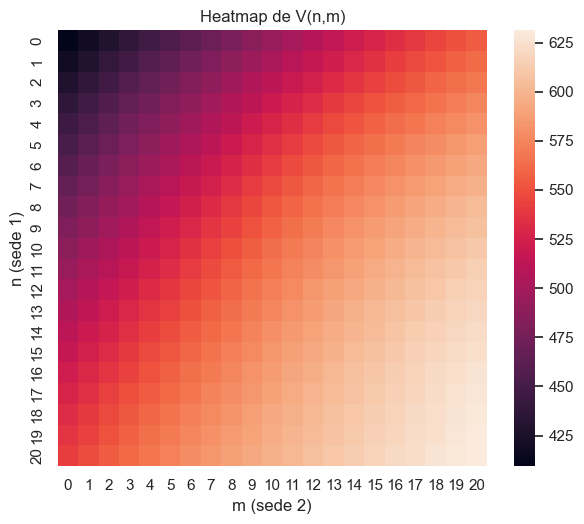

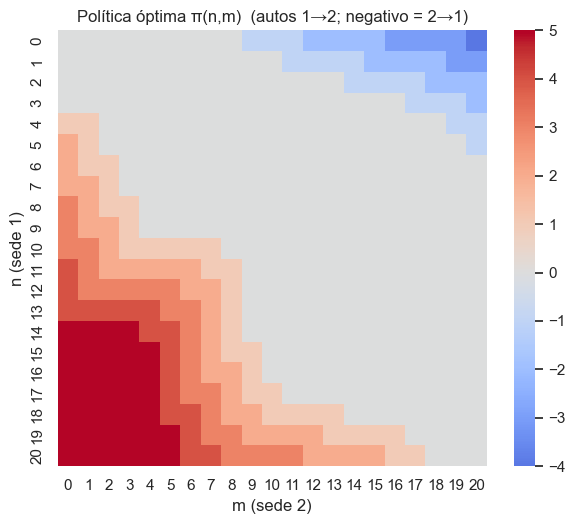

In [9]:
plt.figure(figsize=(6.2, 5.4))
sns.heatmap(V, annot=False)
plt.title("Heatmap de V(n,m)")
plt.xlabel("m (sede 2)")
plt.ylabel("n (sede 1)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6.2, 5.4))
sns.heatmap(pi, annot=False, center=0, cmap="coolwarm")
plt.title("Política óptima π(n,m)  (autos 1→2; negativo = 2→1)")
plt.xlabel("m (sede 2)")
plt.ylabel("n (sede 1)")
plt.tight_layout()
plt.show()


## 10) Validaciones rápidas

- **Probabilidades:** cada fila de `P¹` y `P²` ≈ 1.  
- **Recompensas máximas:** `R₁[20] ≈ 30`, `R₂[20] ≈ 40`.  
- **Política:** `π(n,m)` siempre dentro de `[-5,5]` y respeta factibilidad por estado.

---

### ⚠️ Pitfalls comunes (ya cubiertos):

1. **Acciones inválidas:** mover más autos de los disponibles o superar 20.  
2. **Costo de movimiento omitido:** falta de `-2|a|`.  
3. **Cola de Poisson:** no acumular la probabilidad en la columna 20.  
4. **Normalización:** filas de `P¹`, `P²` que no sumen 1.


In [10]:
print("Máx |fila - 1| P1:", np.abs(P1.sum(axis=1) - 1).max())
print("Máx |fila - 1| P2:", np.abs(P2.sum(axis=1) - 1).max())
print("R1[20] ≈", R1[20], "  R2[20] ≈", R2[20])
print("π rango:", pi.min(), "→", pi.max())


Máx |fila - 1| P1: 4.440892098500626e-16
Máx |fila - 1| P2: 2.220446049250313e-16
R1[20] ≈ 29.999999999863725   R2[20] ≈ 39.99999997659085
π rango: -4 → 5


## 11) Conclusión

- Con `λ₂ = 4` (demanda más alta en sede 2) y `μ₁ = 3` (más devoluciones en sede 1),  
  la **política óptima** tiende a mover autos **de sede 1 → sede 2** cuando allí faltan.  

- El movimiento está limitado por:  
  - **Tope:** máximo 5 autos por noche.  
  - **Costo:** `-2 * |a|` por traslado.  

- Los valores `V(n, m)` resultan **más altos** cuando el inventario en cada sede  
  se alinea mejor con la **demanda esperada**.

  Además, se verificó que las matrices de transición están bien normalizadas y que la política obtenida es consistente con los valores, confirmando la corrección de la solución.
